# Model development

In [5]:
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys

sys.path.append('../scripts')
from sql_functions import create_sql_connection, execute_sql_command
from global_vbls import data_path, db_file

## Load the data

In [57]:
conn = create_sql_connection(db_file)
obs_df = pd.read_sql("SELECT * FROM o3_obs_nyc",conn,parse_dates='timestamp_local',
                     index_col='timestamp_local')
conn.close()

obs_df = obs_df.fillna(value=pd.np.nan)
obs_df.head()

,site_id,o3_ppm
timestamp_local,,
2003-01-01 00:00:00,36583,0.001
2003-01-01 01:00:00,36583,0.001
2003-01-01 02:00:00,36583,0.001
2003-01-01 03:00:00,36583,0.001
2003-01-01 04:00:00,36583,0.001


## Prepare the data
### Select data for NYC model
For now, only using data from station number 133 in the Bronx for the NYC model. 

In [58]:
observations = obs_df[(obs_df['site_id']=='365133')].rename(mapper={'o3_ppm':'obs_o3'},axis=1)

### Check for bad data
The EPA already did a bunch of data cleaning for me, so I don't expect any major problems. To verify the data's cleanliness, I'll plot a time series of the ozone observations. 

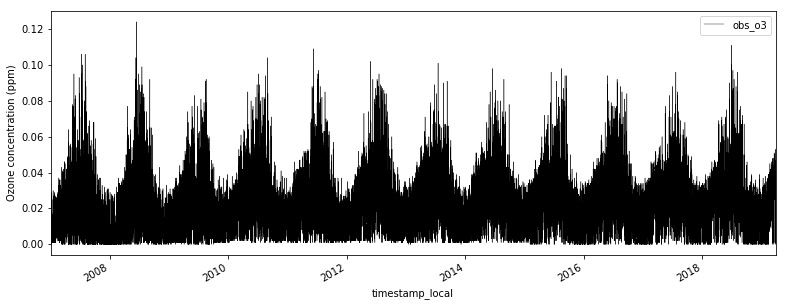

In [59]:
fig = plt.figure(figsize=[13,5])
ax = fig.add_subplot(111)
observations.plot(ax=ax, color='k', linewidth=0.4)
ax.set_ylabel('Ozone concentration (ppm)')
plt.show()

The data looks clean! 

## Create moving average-type model

This model uses only previous values from the time series to predict future values. 

The model assumes that the modeled time series takes the following form: 

$$Y_t = L_t + S_t + \big( \mu + \sum_{i=1}^{k} \theta_i \epsilon_{t-i} + \epsilon_t \big), $$

where $Y_t$ is the value of the time series value at time $t$, $L_t$ is the long-term drift component at time $t$, $S_t$ is the seasonal drift component at time $t$, $\epsilon_t$ is the error at at time $t$, $\mu$ is the mean error across the entire time series, and the values of $\theta_i$ are the coefficients that relate the previous errors to $Y_t$. Under this assumption, a predictive model can be built by removing the long-term and seasonal drift components, and then fitting a moving average-type model to the stationary result.

Steps for building the model: 
* Determine the long-term and seasonal drift components. Because we're dealing with meteorological data, which changes cyclically with the physical season and time of day, the seasonal drift component should be split into two separate seasonal components: one that represents the physical season, and another that represents the time of day. 
* Make the data stationary: remove the long-term and seasonal drifts through subtraction. 
* Then fit a moving-average type model to the stationary time series. 

Steps for making predictions with the model: 
* Us the moving-average model to predict the stationary value for that time. 
* Calculate the long-term and seasonal drift components for the datapoint. Add the seasonal and long-term drifts to the predicted stationary value. 
* Then you're left with a single prediction! 
* For predictions several timesteps into the future: use the stationary prediction for the previous timestep to the get the stationary prediction for the current timestep, etc. until stationary predictions exist for all timesteps that you want predictions for. Add the long-term drift and seasonal components to each prediction. Then you have the predictions! 

Note: this type of model is pretty impractical for prediction when the preceding values aren't immediately available, because the predictions depend entirely on the preceding values!

### Start with the O3 time series

In [39]:
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

class longTermDrift_exponential(TransformerMixin, BaseEstimator): 
    """Transformer to remove long-term drift from a time series using an 
    exponential model. Operates on Pandas data series with datetime indices.
    """
    
    def __init__(self):
        return None
    
    def check_type_X(self,X): 
        """Check that the input is a Pandas data series with a datetime index."""
        if (type(X) is not pd.core.series.Series or 
            type(X.index) is not pd.core.indexes.datetimes.DatetimeIndex): 
            raise(TypeError('X must be a Pandas data series with a datetime index'))
        return None
    
    def fit(self,X): 
        
        self.check_type_X(X)
        
        # Fit exponential model: take log, then fit linear model. Independent
        # variable is the julian day. 
        from sklearn.linear_model import LinearRegression
        X = X[X>0].dropna()
        dep_vbl = np.log(np.array(X)).reshape(-1,1)
        indep_vbl = np.array(X.index.to_julian_date()).reshape(-1,1)
        lin_reg = LinearRegression().fit(indep_vbl,dep_vbl)
        
        # Save linear model as attribute
        self.lin_reg = lin_reg
        
        return self

    def transform(self,X): 
        
        self.check_type_X(X)
        
        # Calculate the exponential model's prediction at each time. 
        indep_var_vals = np.array(X.index.to_julian_date()).reshape(-1,1)
        exp_model_preds = np.exp(self.lin_reg.predict(indep_var_vals))
        
        # Divide the values of X by the exponential model's predictions. 
        return X-np.squeeze(exp_model_preds)
        
    def inverse_transform(self,X):
        
        self.check_type_X(X)
        
        # Calculate the exponential model's prediction at each time. 
        indep_var_vals = np.array(X.index.to_julian_date()).reshape(-1,1)
        exp_model_preds = np.exp(self.lin_reg.predict(indep_var_vals))
        
        # Multiply the values of X by the exponential model's predictions. 
        return X+np.squeeze(exp_model_preds)
        
        

In [40]:
class seasonalDrift_polynomial(TransformerMixin, BaseEstimator): 
    """Transformer to remove seasonal drift from a time series using a
    polynomial model. Operates on Pandas data series with datetime indices.
    """
    
    def __init__(self,poly_deg=5,seasonal_timescale='dayofyear'):
        self.poly_deg = poly_deg
        self.check_seas_tscale(seasonal_timescale)
        self.seasonal_timescale = seasonal_timescale
        return None
    
    def check_type_X(self,X): 
        """Check that the input is a Pandas data series with a datetime index."""
        if (type(X) is not pd.core.series.Series or 
            type(X.index) is not pd.core.indexes.datetimes.DatetimeIndex): 
            raise(TypeError('X must be a Pandas data series with a datetime index'))
        return None
    
    def check_seas_tscale(self,seasonal_timescale): 
        """Check that the input seasonal_timescale has an acceptable value."""
        if seasonal_timescale not in ['dayofyear','week','hour']: 
            raise(ValueError("seasonal_timescale must be in: ['dayofyear','week','hour']"))
        return None
    
    def create_indep_vbl(self,X,seasonal_timescale): 
        """Creates model independent variable, based on 'seasonal_timescale' 
        class attribute.
        """
        if seasonal_timescale == 'week': 
            indep_vbl = np.array(X.index.dayofyear//7).reshape(-1,1)
        elif seasonal_timescale == 'hour': 
            indep_vbl = np.array(X.index.hour).reshape(-1,1)
        elif seasonal_timescale == 'dayofyear': 
            indep_vbl = np.array(X.index.dayofyear).reshape(-1,1)
        return indep_vbl
    
    def fit(self,X): 
        
        # Prepare data for polynomial model
        self.check_type_X(X)
        X = X.dropna()
        indep_vbl = self.create_indep_vbl(X,self.seasonal_timescale)
        dep_vbl = np.array(X).reshape(-1,1)
        
        # Fit polynomial model
        poly_feat = PolynomialFeatures(self.poly_deg).fit(indep_vbl)
        indep_vbl_p = poly_feat.transform(indep_vbl)
        lin_reg = LinearRegression().fit(indep_vbl_p,dep_vbl)
        
        # Save polynomial features transformer, linear model as attributes. 
        self.poly_feat = poly_feat
        self.lin_reg = lin_reg
        
        return self

    def transform(self,X): 
        
        self.check_type_X(X)
        
        # Get the seasonal drift value at each time. 
        indep_vbl = self.create_indep_vbl(X,self.seasonal_timescale)
        indep_vbl_p = self.poly_feat.transform(indep_vbl)
        poly_model_preds = self.lin_reg.predict(indep_vbl_p)
        
        # Divide the values of X by the seasonal drift values. 
        return X-np.squeeze(poly_model_preds)
        
    def inverse_transform(self,X):
        
        self.check_type_X(X)
        
        # Get the seasonal drift value at each time. 
        indep_vbl = self.create_indep_vbl(X,self.seasonal_timescale)
        indep_vbl_p = self.poly_feat.transform(indep_vbl)
        poly_model_preds = self.lin_reg.predict(indep_vbl_p)
        
        # Multiply the values of X by the seasonal drift values. 
        return X+np.squeeze(poly_model_preds)



In [50]:
time_series = observations['obs_o3']
time_series = time_series.resample('H').agg('nearest')

L_transformer = longTermDrift_exponential().fit(time_series)
time_series_tr1 = L_transformer.transform(time_series)

S_transformer_s = seasonalDrift_polynomial(poly_deg=6,seasonal_timescale='week').fit(time_series_tr1)
time_series_tr2 = S_transformer_s.transform(time_series_tr1)

S_transformer_d = seasonalDrift_polynomial(poly_deg=6,seasonal_timescale='hour').fit(time_series_tr2)
time_series_tr3 = S_transformer_d.transform(time_series_tr2)

The "stationary" time series is definitely more stationary than the original time series, but isn't perfectly stationary: peaks and troughs are still more extreme in summer than in winter. I'm not sure how to remove these seasonal components--removing them with division instead of subtraction doesn't help. Maybe I could standardize the observations using some "variance" factor, which is larger in summer than in winter? I haven't tried this, but am definitely interested in trying it at some later date. 

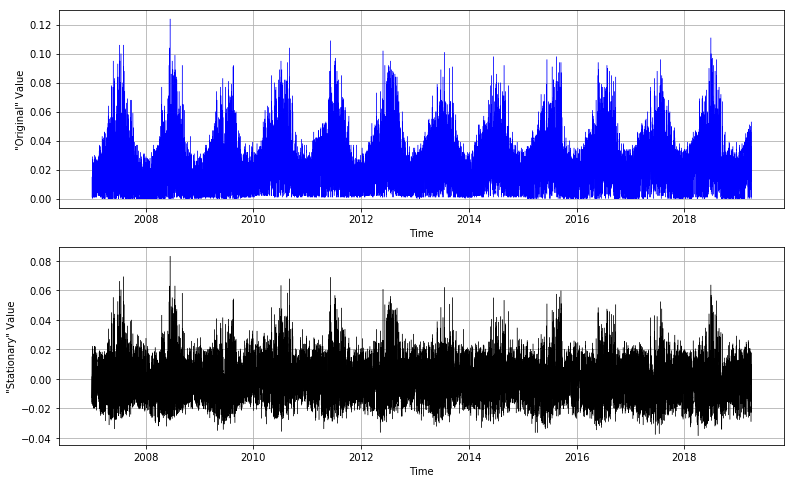

In [51]:
fig = plt.figure(figsize=[13,8])
ax = fig.add_subplot(211)
ax.plot(time_series,color='b',alpha=1,linewidth=0.4,label='original')
ax.set_xlabel('Time')
ax.set_ylabel('"Original" Value')
ax.grid(True)

ax = fig.add_subplot(212)
ax.plot(time_series_tr3,color='k',alpha=1,linewidth=0.4,label='stationary')
ax.set_xlabel('Time')
ax.set_ylabel('"Stationary" Value')
ax.grid(True)

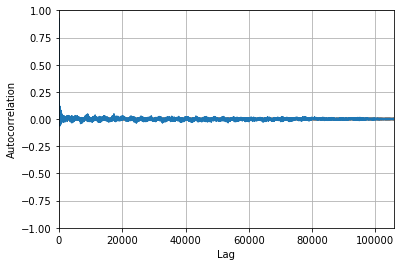

In [43]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(time_series_tr3.dropna())

It's time to build the moving average model. I'll use six-hourly values from the previous seven days as predictors (lags of 6, 12, 18, 24, ..., 162, 168 hours). The autocorrelations drop off to low (and relatively steady) values at longer lags. 

(0, 120)

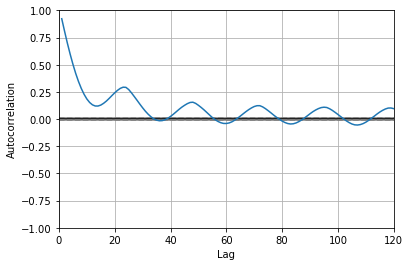

In [44]:
autocorrelation_plot(time_series_tr3.dropna())
plt.xlim([0,24*5])

In [ ]:
class movingAverageModel(RegressorMixin, BaseEstimator): 
    
    def __init__(self,lags = [24*i for i in range(1,6)]):
        self.lags = lags
        return None
    
    def check_timestamps_equal_spacing(self,timestamps): 
        if len(list(set(np.diff(timestamps))))>1: 
            raise(ValueError("Input timestamps must be spaced equally!"))
        return None
    
    def create_lagged_df(self,timestamps,observations): 
        mean_obs = np.nanmean(observations) 
        observations = observations-mean_obs 
        lag_df = pd.DataFrame({'timestamp_local':timestamps,'obs':observations})\
                             .set_index('timestamp_local')
        for lag in self.lags: 
            lag_df['lag_'+str(lag)] = lag_df['obs'].shift(lag)
        return lag_df,mean_obs
    
    def get_lagged_vals(self,timestamp,timestamps,predicted_vals): 
        lagged_vals = []
        for lag in self.lags: 
            lagged_tstamp = timestamp - (lag*pd.Timedelta('1 hours'))
            if lagged_tstamp in timestamps: 
                lagged_vals.append(predicted_vals[list(timestamps).index(lagged_tstamp)])
            else: 
                try: 
                    lagged_vals.append(self.saved_obs.loc[lagged_tstamp])
                except KeyError: 
                    lagged_vals.append(0)
        return np.array(lagged_vals).reshape(1,-1)
        
    
    def fit(self,timestamps,observations): 
        
        self.check_timestamps_equal_spacing(timestamps)
        
        lag_df,mean_obs = self.create_lagged_df(timestamps,observations)
        lag_df = lag_df.dropna()
        
        self.mean_obs = mean_obs
        self.saved_obs = lag_df['obs']
        
        indep_vbl = np.array(lag_df[['lag_'+str(lag) for lag in self.lags]])
        dep_vbl = np.array(lag_df['obs']).reshape(-1,1)
        lin_reg = LinearRegression(fit_intercept=False).fit(indep_vbl,dep_vbl) 
        #lin_reg = RandomForestRegressor(max_depth=3).fit(indep_vbl,dep_vbl)
        self.lin_reg = lin_reg
        
        return self
    
    def predict(self,timestamps): 
        
        predicted_vals = []
        for timestamp in timestamps: 
            lagged_vals = self.get_lagged_vals(timestamp,timestamps,predicted_vals)
            predicted_vals.append(self.lin_reg.predict(lagged_vals))
        
        return np.array(predicted_vals).reshape(-1,1)

    
def add_drifts(timestamps,predictions,mean_X,transformers_list): 
    X = pd.DataFrame({'timestamp_local':timestamps,'obs':np.squeeze(predictions)+mean_X})\
                     .set_index('timestamp_local')['obs']
    for transformer in transformers_list: 
        X = transformer.inverse_transform(X)
    return X

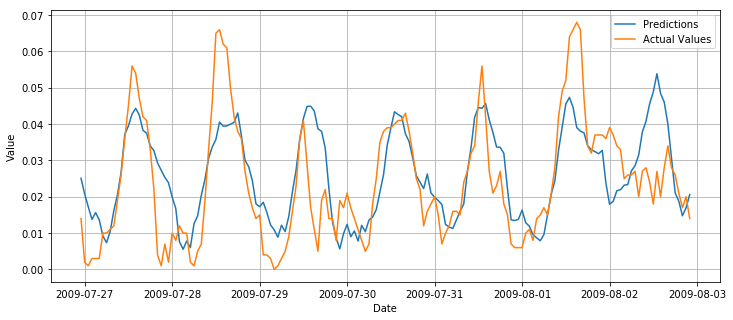

In [55]:
# Fit moving average model
timestamps = time_series_tr3.index.values
observations = np.array(time_series_tr3)
ma_model = movingAverageModel(lags=[6*i for i in range(1,29)]).fit(timestamps,observations)

# Make predictions for a five day period
start_ind = 22500
end_ind = start_ind+7*24
transformers_list = [S_transformer_d,S_transformer_s,L_transformer]
pred_tstamps = time_series_tr3.iloc[start_ind:end_ind].index.values
stationary_preds = ma_model.predict(pred_tstamps)
final_preds = add_drifts(pred_tstamps,stationary_preds,ma_model.mean_obs,transformers_list)

# Plot
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111)
ax.plot(final_preds,label='Predictions')
ax.plot(time_series.iloc[start_ind:end_ind],label='Actual Values')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

The model is pretty good at capturing the dirunal and seasonal variations in the O3 concentrations (this isn't so surprising though--it's built directly into the model). Unfortunately, the model has some trouble predicting ozone concentrations on the days with particularly high ozone levels, and on days when the ozone level doesn't rise much from overnight values. I hope a model that relates environmental conditions to the ozone concentrations will work better? That's coming next. 

In [56]:
conn.close()